In [2]:
import warnings
import joblib
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, validation_curve
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

## read dataset
def load_data_diabetes():
    data = pd.read_csv("nyc-rolling-sales.csv")
    return data

df = load_data_diabetes()
df.head()


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [25]:
df.dtypes

Unnamed: 0                         int64
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

In [3]:
df["APARTMENT NUMBER"].values

array([' ', ' ', ' ', ..., ' ', ' ', ' '], dtype=object)

In [4]:
df["EASE-MENT"].values

array([' ', ' ', ' ', ..., ' ', ' ', ' '], dtype=object)

In [5]:
## drop some coloumns
df_ = df.drop("Unnamed: 0", axis=1)
df_ = df_.drop("SALE DATE", axis=1)
df_ = df_.drop("EASE-MENT", axis=1)
df_ = df_.drop("APARTMENT NUMBER", axis=1)
## 2 high correlations
df_ = df_.drop("TOTAL UNITS", axis=1)
df_ = df_.drop("ADDRESS", axis=1)
df_ = df_.drop("ZIP CODE", axis=1)


# Display the head of the final DataFrame
df_.head()


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,5,0,1633,6440,1900,2,C2,6625000
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,28,3,4616,18690,1900,2,C7,-
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,16,1,2212,7803,1900,2,C7,-
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10,0,2272,6794,1913,2,C4,3936272
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,6,0,2369,4615,1900,2,C2,8000000


In [6]:

# We remove characters like '-', ',' in the SALE PRICE' column
df_['SALE PRICE'] = df_['SALE PRICE'].astype(str).replace({',': '', '-': ''}, regex=True)
df_['SALE PRICE'] = df_['SALE PRICE'].astype(str).replace({',': '', '-': '', ' ': ''}, regex=True)
#We delete rows with NaN values which cannot be converted to numbers
# NaN değerleri (sayıya çevrilemeyen) satırları siliyoruz
df_ = df_.dropna(subset=['SALE PRICE'])
df_.head(20)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,5,0,1633,6440,1900,2,C2,6625000
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,28,3,4616,18690,1900,2,C7,
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,16,1,2212,7803,1900,2,C7,
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,10,0,2272,6794,1913,2,C4,3936272
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,6,0,2369,4615,1900,2,C2,8000000
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,20,0,2581,9730,1900,2,C4,
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,8,0,1750,4226,1920,2,C4,3192840
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,44,2,5163,21007,1900,2,C7,
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,15,0,1534,9198,1920,2,D5,
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,24,0,4489,18523,1920,2,D9,16232000


In [7]:

# We remove characters like '-', ',' in the SALE PRICE' column
df_['SALE PRICE'] = df_['SALE PRICE'].astype(str).replace({',': '', '-': '', ' ': ''}, regex=True)
df_['LAND SQUARE FEET'] = df_['LAND SQUARE FEET'].astype(str).replace({',': '', '-': '', ' ': ''}, regex=True)
df_['GROSS SQUARE FEET'] = df_['LAND SQUARE FEET'].astype(str).replace({',': '', '-': '', ' ': ''}, regex=True)
# Convert the 'SALE PRICE' column back to numeric and mark errors as NaN
df_['SALE PRICE'] = pd.to_numeric(df_['SALE PRICE'], errors='coerce')

#We delete rows with NaN values which cannot be converted to numbers
# NaN değerleri (sayıya çevrilemeyen) satırları siliyoruz
df_ = df_.dropna(subset=['SALE PRICE'])
df_ = df_.sort_values(by='COMMERCIAL UNITS', ascending=False)
df_.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
64831,4,JAMAICA,33 EDUCATIONAL FACILITIES,4,9827,39,W9,0,2261,2940,2940,1920,4,W9,315000.0
54595,4,EAST ELMHURST,26 OTHER HOTELS,4,1641,1,H3,0,436,200700,200700,1981,4,H3,33663600.0
54596,4,EAST ELMHURST,26 OTHER HOTELS,4,1641,1,H3,0,436,200700,200700,1981,4,H3,33663600.0
2565,1,FINANCIAL,25 LUXURY HOTELS,4,52,8,H2,0,318,6109,6109,2014,4,H2,203345000.0
6681,1,KIPS BAY,26 OTHER HOTELS,4,929,38,H8,0,254,18344,18344,2015,4,H8,174000000.0


In [8]:
df_.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING CLASS AT PRESENT          object
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                        float64
dtype: object

In [9]:
## All rows with SALE PRICE value 0 are cleared
#df_ = df_.drop(df_[df_['SALE PRICE'] == 0.0].index)
## change type
df_['TAX CLASS AT TIME OF SALE'] = df_['TAX CLASS AT TIME OF SALE'].astype('category')
#df_['TAX CLASS AT PRESENT'] = df_['TAX CLASS AT PRESENT'].astype('category')
df_['LAND SQUARE FEET'] = pd.to_numeric(df_['LAND SQUARE FEET'], errors='coerce')
## coerce-> Write NaN instead
df_['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df_['BOROUGH'] = df_['BOROUGH'].astype('category')

In [10]:
df_.dtypes

BOROUGH                           category
NEIGHBORHOOD                        object
BUILDING CLASS CATEGORY             object
TAX CLASS AT PRESENT                object
BLOCK                                int64
LOT                                  int64
BUILDING CLASS AT PRESENT           object
RESIDENTIAL UNITS                    int64
COMMERCIAL UNITS                     int64
LAND SQUARE FEET                   float64
GROSS SQUARE FEET                  float64
YEAR BUILT                           int64
TAX CLASS AT TIME OF SALE         category
BUILDING CLASS AT TIME OF SALE      object
SALE PRICE                         float64
dtype: object

In [11]:
## SALE PRICE 0 olamaz. 
df_ = df_[df_['SALE PRICE'] > 0]
df_ = df_[df_['YEAR BUILT'] > 0]
df_['SALE PRICE'] = np.log1p(df_['SALE PRICE'])

#Log Dönüşümü: SALE PRICE değerleri çok büyük bir aralıkta değişiyorsa 
# (örneğin 0 ile 16,232,000 arasında), log dönüşümü gibi bir dönüşüm uygulayarak
# daha dengeli bir dağılım elde edebilirsiniz.
df_ = df_.sort_values(by='SALE PRICE', ascending=True)
df_.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
32177,3,CANARSIE,01 ONE FAMILY DWELLINGS,1,8055,55,A2,1,0,3250.0,860.0,1935,1,A2,0.693147
36995,3,EAST NEW YORK,07 RENTALS - WALKUP APARTMENTS,2A,4074,11,C3,4,0,2500.0,3900.0,1930,2,C3,0.693147
44404,3,PARK SLOPE,01 ONE FAMILY DWELLINGS,1,1093,14,A4,1,0,1600.0,3600.0,1900,1,A4,0.693147
21532,2,MORRISANIA/LONGWOOD,07 RENTALS - WALKUP APARTMENTS,2,2696,75,C7,71,7,14579.0,75672.0,1910,2,C7,0.693147
44405,3,PARK SLOPE,01 ONE FAMILY DWELLINGS,1,1093,14,A4,1,0,1600.0,3600.0,1900,1,A4,0.693147


In [12]:
df_cleaned = df_.sort_values(by='YEAR BUILT')
df_ = df_[df_['YEAR BUILT'] > 0]
df_cleaned.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
957,1,CHELSEA,29 COMMERCIAL GARAGES,4,799,70,G6,0,0,2125.0,NaN,1111,4,G6,15.920711
35803,3,DOWNTOWN-METROTECH,13 CONDOS - ELEVATOR APARTMENTS,2,2058,1108,R4,1,0,0.0,0.0,1800,2,R4,13.997833
35810,3,DOWNTOWN-METROTECH,13 CONDOS - ELEVATOR APARTMENTS,2,2058,1153,R4,1,0,0.0,0.0,1800,2,R4,14.169683
35808,3,DOWNTOWN-METROTECH,13 CONDOS - ELEVATOR APARTMENTS,2,2058,1143,R4,1,0,0.0,0.0,1800,2,R4,14.038655
35800,3,DOWNTOWN-METROTECH,13 CONDOS - ELEVATOR APARTMENTS,2,2058,1077,R4,1,0,0.0,0.0,1800,2,R4,13.910822


In [13]:
## check duplicated data set
sum(df_cleaned.duplicated(df_cleaned.columns))

868

In [14]:
#Delete the duplicates and check that it worked
df_cleaned = df_cleaned.drop_duplicates(df_cleaned.columns, keep='last')
sum(df_cleaned.duplicated(df_cleaned.columns))

0

In [15]:
df_cleaned .shape

(54581, 15)

In [16]:
df_cleaned.dtypes

BOROUGH                           category
NEIGHBORHOOD                        object
BUILDING CLASS CATEGORY             object
TAX CLASS AT PRESENT                object
BLOCK                                int64
LOT                                  int64
BUILDING CLASS AT PRESENT           object
RESIDENTIAL UNITS                    int64
COMMERCIAL UNITS                     int64
LAND SQUARE FEET                   float64
GROSS SQUARE FEET                  float64
YEAR BUILT                           int64
TAX CLASS AT TIME OF SALE         category
BUILDING CLASS AT TIME OF SALE      object
SALE PRICE                         float64
dtype: object

In [17]:
## Capture numerical and categorical variables
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    #cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car  = grab_col_names(df_cleaned )
print(num_cols)

Observations: 54581
Variables: 15
cat_cols: 7
num_cols: 8
cat_but_car: 4
num_but_cat: 2
['BLOCK', 'LOT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE']


In [18]:
cat_cols

['NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BOROUGH',
 'TAX CLASS AT TIME OF SALE']

In [19]:
 num_cols

['BLOCK',
 'LOT',
 'RESIDENTIAL UNITS',
 'COMMERCIAL UNITS',
 'LAND SQUARE FEET',
 'GROSS SQUARE FEET',
 'YEAR BUILT',
 'SALE PRICE']

In [20]:
## Numerik ve kategorik değişkenleri yakala
num_deg = df_cleaned .select_dtypes(include=['int64', 'float64']).columns
cat_deg = df_cleaned .select_dtypes(include=['object']).columns

print("Numeric Veriable:", num_deg)
print("Categoric Veriable:", cat_deg)

Numeric Veriable: Index(['BLOCK', 'LOT', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE'],
      dtype='object')
Categoric Veriable: Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
       'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE'],
      dtype='object')


## ANALYSIS OF CATEGORICAL VARIABLES

In [21]:

## 1. olarak Kategorik değişkenlerin analizi yapılır.
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
for col in cat_cols:
    cat_summary(df_cleaned , col)

                          NEIGHBORHOOD     Ratio
NEIGHBORHOOD                                    
FLUSHING-NORTH                    2034  3.726572
UPPER EAST SIDE (59-79)           1319  2.416592
UPPER EAST SIDE (79-96)           1195  2.189407
MIDTOWN EAST                       984  1.802825
UPPER WEST SIDE (59-79)            853  1.562815
...                                ...       ...
FRESH KILLS                          2  0.003664
CITY ISLAND-PELHAM STRIP             1  0.001832
PELHAM BAY                           1  0.001832
BRONX PARK                           1  0.001832
EAST RIVER                           1  0.001832

[253 rows x 2 columns]
                                              BUILDING CLASS CATEGORY  \
BUILDING CLASS CATEGORY                                                 
01 ONE FAMILY DWELLINGS                                         12953   
10 COOPS - ELEVATOR APARTMENTS                                  11045   
02 TWO FAMILY DWELLINGS                        

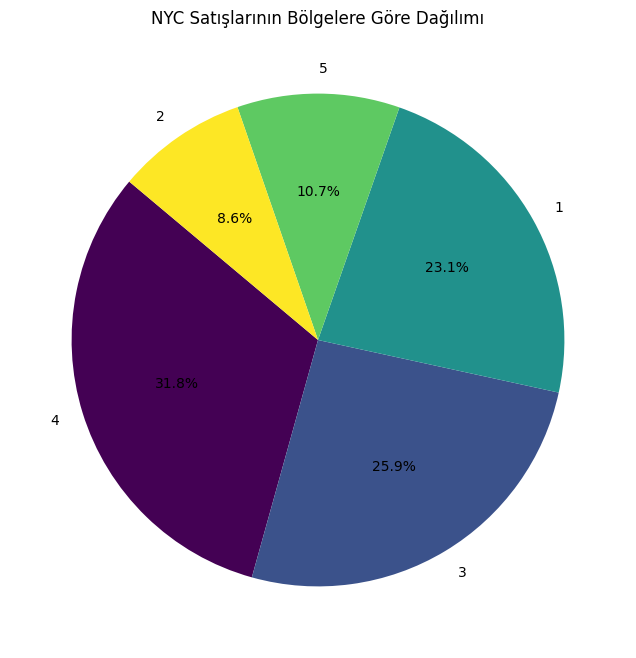

In [22]:
plt.figure(figsize=(8, 8)) 
df_cleaned['BOROUGH'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, cmap="viridis") 
plt.title("NYC Satışlarının Bölgelere Göre Dağılımı") 
plt.ylabel("") 
plt.show()

### ANALYSIS OF NUMERICAL VARIABLES

count    54581.000000
mean      4246.054011
std       3598.200172
min          1.000000
5%         238.000000
10%        620.000000
20%       1144.000000
30%       1484.000000
40%       2112.000000
50%       3293.000000
60%       4668.000000
70%       5636.000000
80%       7109.000000
90%       9309.000000
95%      11739.000000
99%      15598.000000
max      16319.000000
Name: BLOCK, dtype: float64


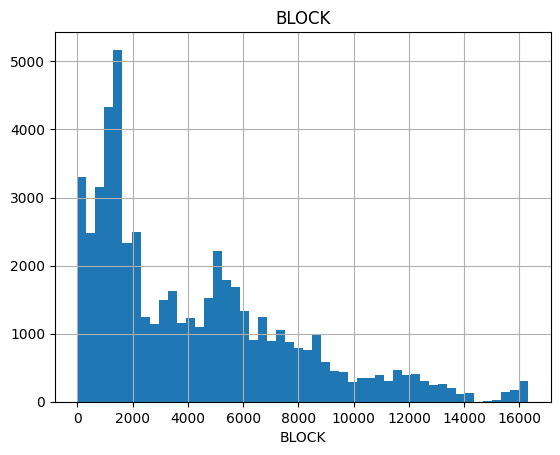

#####################################
count    54581.000000
mean       330.627160
std        594.394412
min          1.000000
5%           1.000000
10%          6.000000
20%         16.000000
30%         25.000000
40%         35.000000
50%         47.000000
60%         62.000000
70%        107.000000
80%       1005.000000
90%       1189.000000
95%       1377.000000
99%       2067.000000
max       9002.000000
Name: LOT, dtype: float64


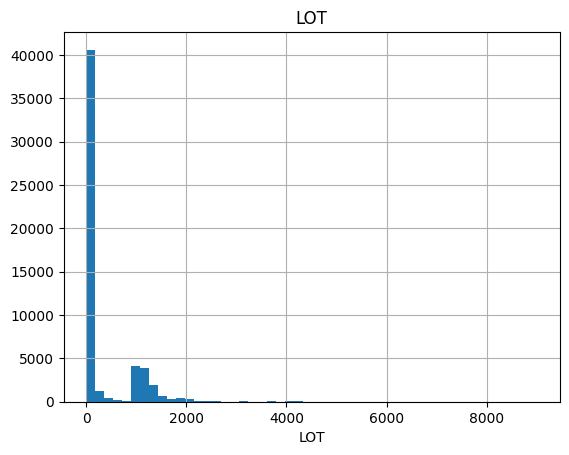

#####################################
count    54581.000000
mean         0.664380
std          0.587117
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.693147
40%          0.693147
50%          0.693147
60%          0.693147
70%          0.693147
80%          1.098612
90%          1.098612
95%          1.386294
99%          2.833213
max          7.520235
Name: RESIDENTIAL UNITS, dtype: float64


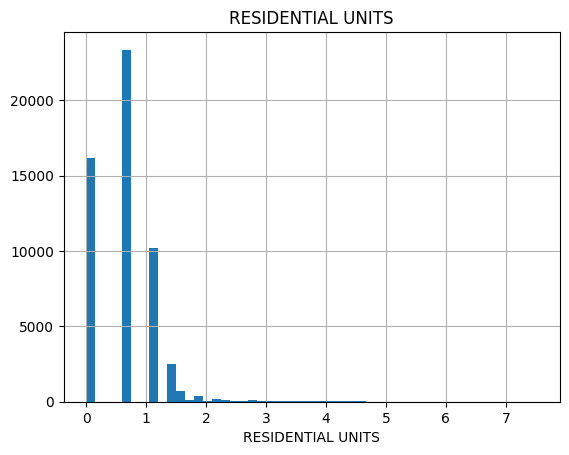

#####################################
count    54581.000000
mean         0.167641
std         10.104812
min          0.000000
5%           0.000000
10%          0.000000
20%          0.000000
30%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
70%          0.000000
80%          0.000000
90%          0.000000
95%          1.000000
99%          2.000000
max       2261.000000
Name: COMMERCIAL UNITS, dtype: float64


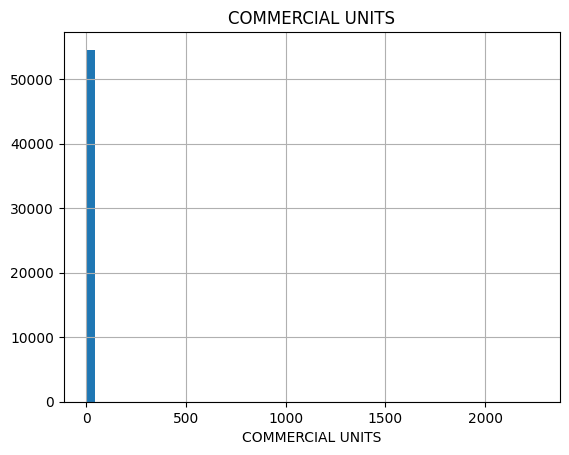

#####################################
count    36008.000000
mean         6.483390
std          3.123914
min          0.000000
5%           0.000000
10%          0.000000
20%          7.039660
30%          7.496097
40%          7.601402
50%          7.741099
60%          7.824446
70%          8.006701
80%          8.294300
90%          8.517393
95%          8.782116
99%          9.710879
max         15.257311
Name: LAND SQUARE FEET, dtype: float64


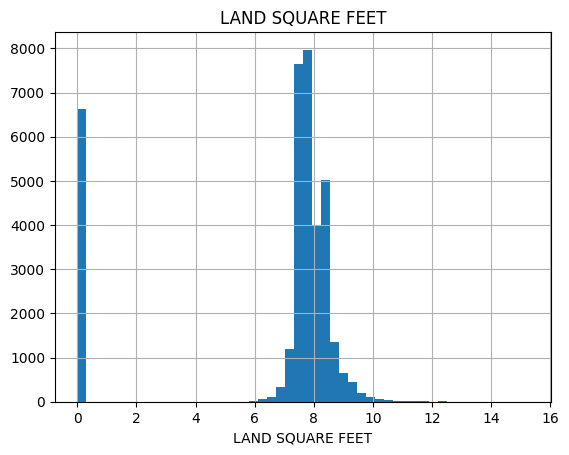

#####################################
count    35849.000000
mean         6.221385
std          3.056114
min          0.000000
5%           0.000000
10%          0.000000
20%          6.683361
30%          7.082549
40%          7.233455
50%          7.383368
60%          7.544861
70%          7.698483
80%          7.896925
90%          8.188967
95%          8.640684
99%         10.583181
max         15.137417
Name: GROSS SQUARE FEET, dtype: float64


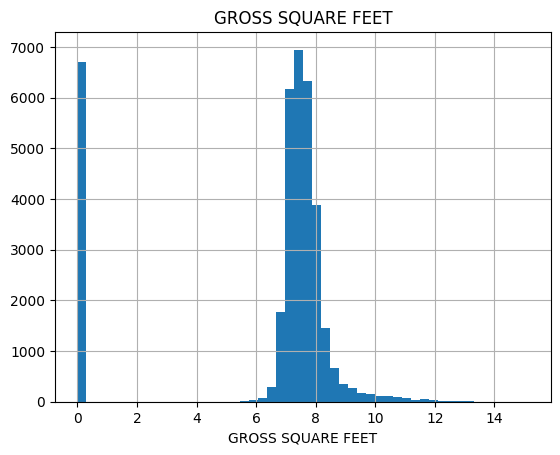

#####################################
count    54581.000000
mean      1950.775764
std         34.503468
min       1111.000000
5%        1901.000000
10%       1910.000000
20%       1920.000000
30%       1927.000000
40%       1931.000000
50%       1948.000000
60%       1955.000000
70%       1964.000000
80%       1986.000000
90%       2007.000000
95%       2014.000000
99%       2016.000000
max       2017.000000
Name: YEAR BUILT, dtype: float64


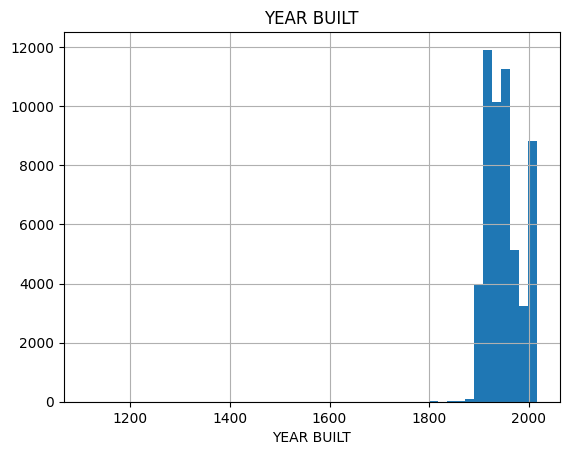

#####################################
count    54581.000000
mean        13.233899
std          1.733111
min          0.693147
5%          11.775297
10%         12.254868
20%         12.691584
30%         12.959847
40%         13.158070
50%         13.345509
60%         13.527830
70%         13.737550
80%         14.046623
90%         14.603968
95%         15.180313
99%         16.454568
max         21.516258
Name: SALE PRICE, dtype: float64


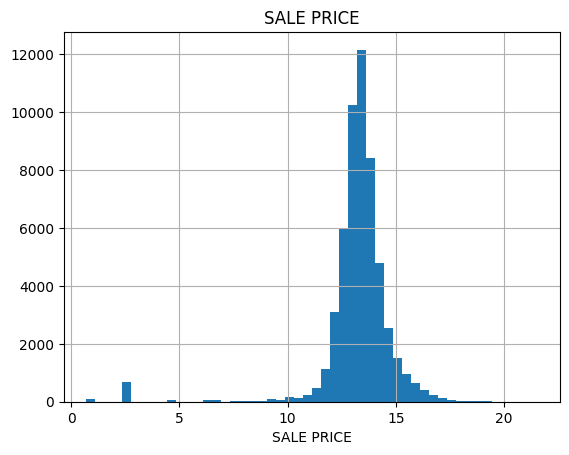

#####################################


In [23]:
# NUMERİK DEĞİŞKENLERİN ANALİZİ

##sütununuzda çok büyük değerler var ve histogram grafiğinizde veri sıkışık görünüyorsa uygulanır.
## LAND SQUARE FEET sütununda çok büyük değerler ve çok küçük değerler olabilir. 
## Logaritmik dönüşüm bu değerlerin daha dar bir aralıkta toplanmasını sağlar ve veri analizini kolaylaştırır.
df_cleaned['LAND SQUARE FEET'] = np.log1p(df_cleaned['LAND SQUARE FEET'])
df_cleaned['GROSS SQUARE FEET'] = np.log1p(df_cleaned['GROSS SQUARE FEET'])
df_cleaned['RESIDENTIAL UNITS'] = np.log1p(df_cleaned['RESIDENTIAL UNITS'])
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")


for col in num_cols:
    num_summary(df_cleaned, col, True)


C:\Users\semkeles\AppData\Local\Temp\ipykernel_19356\1175992378.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_cleaned['SALE PRICE'])


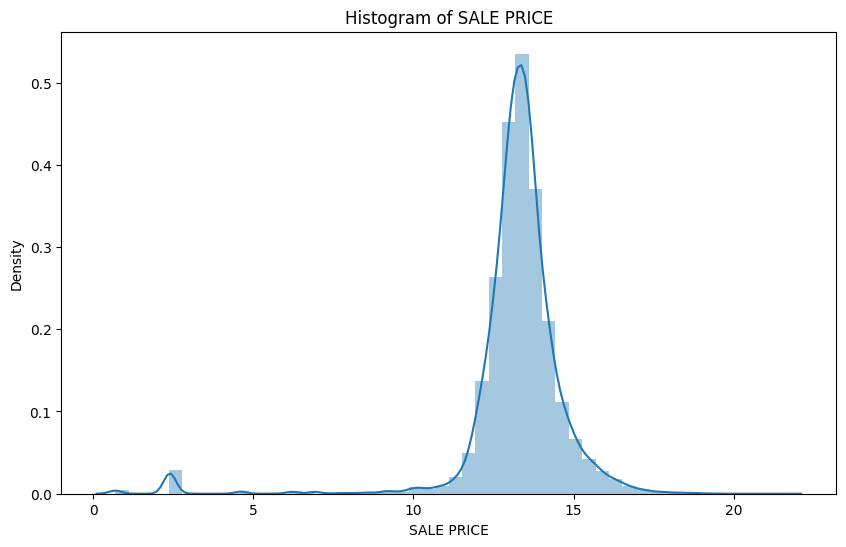

In [24]:
plt.figure(figsize=(10,6))
sns.distplot(df_cleaned['SALE PRICE'])
plt.title('Histogram of SALE PRICE')
plt.show()

### ANALYSIS OF CATEGORICAL VARIABLES BY TARGET


In [ ]:

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    ## quantile method only works on numerical columns
    # Sadece sayısal sütunları seçip quantile işlemi yapalım

check_df(df_cleaned)

In [ ]:
df_cleaned.dtypes

## CORRELATION

In [ ]:
# değişkenler arasındaki ilişkiyi incelemek için korelasyon analizine bakalım
# korelasyon iki değişken arasındaki ilişkinin yönünü ve derecesini gösterir
# -1 ile +1 arasında değişir ve 0 herhangi bir ilişki olmadığını gösterir
# -1 e yaklaştıkça negatif güçlü ilişki, +1 e yaklaştıkça pozitif güçlü ilişki olduğunu gösterir
corr = df_cleaned[num_cols].corr()
corr

In [ ]:
# Korelasyonların gösterilmesi
# renk kırmızıya doğru kaydıkça negatif güçlü ilişki artmaktadır,
# renk koyu maviye doğru kaydıkça da pozitif güçlü ilişki artmaktadır
sns.set(rc={'figure.figsize': (15, 15)})
sns.heatmap(corr, cmap="RdBu")
plt.show()

In [ ]:
## Korelasyon analizi yapacağız.

df_cleaned[num_cols].corr()

# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(df_[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)

In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Select only numeric columns for correlation calculation
    numeric_df = dataframe.select_dtypes(include=['number'])

    # Calculate the correlation matrix
    corr = numeric_df.corr()
    # Take the absolute value of the correlation matrix
    cor_matrix = corr.abs()
    # Create an upper triangle matrix to avoid duplicate checks
    # (Korelasyon matrisinin üst üçgeni oluşturulur, böylece aynı korelasyon çiftlerinin tekrar tekrar kontrol edilmesi önlenir.)
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool_))
    # Find columns with correlation above the threshold [Korelasyonu verilen eşikten (corr_th) yüksek olan sütunlar bulunur.]
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    # Plot the heatmap if requested
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

high_correlated_cols(df_cleaned, plot=False)

## Feature Engineering

In [ ]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)


In [ ]:
df_cleaned.columns

In [ ]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df_cleaned)

In [ ]:
def check_missing_and_empty(dataframe):
    for col in dataframe.columns:
        # Boş karakterleri kontrol et
        empty_count = (dataframe[col] == " ").sum()
        # NaN değerleri kontrol et
        null_count = dataframe[col].isnull().sum()
         # '-' karakterlerini kontrol et
        dash_count = (dataframe[col] == "-").sum()
        # '.' karakterlerini kontrol et
        dot_count = (dataframe[col] == ".").sum()
        print(f"{col} at Colons:")
        print(f"  - Empty Character : {empty_count}")
        print(f"  - NaN Characters: {null_count}")
        print(f"  - '-' Character : {dash_count}")
        print(f"  - '.' Character : {dot_count}\n")

# Tüm sütunları kontrol et
check_missing_and_empty(df_cleaned)


In [ ]:
df_cleaned.columns

In [ ]:
## Kolonlar sağamı çarpık sola mı buluyoruz. 
print("LAND SQUARE FEET Mean:", df_cleaned['LAND SQUARE FEET'].mean())
print("LAND SQUARE FEET Median:", df_cleaned['LAND SQUARE FEET'].median())

print("GROSS SQUARE FEET Mean:", df_cleaned['GROSS SQUARE FEET'].mean())
print("GROSS SQUARE FEET Median:", df_cleaned['GROSS SQUARE FEET'].median())
## GROSS SQUARE FEET mean mediandan büyük sola çarpık median

In [ ]:
df_cleaned.columns

In [ ]:
def quick_missing_imp(dataframe, num_method="median", cat_length=20, target="SALE PRICE"):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    print("# BEFORE")
    print(dataframe[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # Sayısal sütunları median veya mean ile doldurma
    for col in variables_with_na:
        if dataframe[col].dtype != "O":  # Sütun tipi sayısalsa
            if num_method == "mean":
                dataframe[col].fillna(dataframe[col].mean(), inplace=True)
            elif num_method == "median":
                dataframe[col].fillna(dataframe[col].median(), inplace=True)

    print("Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(dataframe[variables_with_na].isnull().sum(), "\n\n")

    return dataframe

# Tüm DataFrame üzerinde eksik değer doldurma işlemi
df_cleaned = quick_missing_imp(df_cleaned, num_method="median")

# Sütunların tamamının korunup korunmadığını kontrol etme
print(df_cleaned.columns)


In [ ]:
df_cleaned.columns

In [ ]:
columns_to_fill = ['BUILDING CLASS AT PRESENT', 'TAX CLASS AT PRESENT']

for col in columns_to_fill:
    # Check if column exists in the DataFrame
    if col in df_cleaned.columns:
        mode_value = df_cleaned[col].mode()[0]  # Get the mode of the column
        df_cleaned[col] = df_cleaned[col].replace(" ", mode_value)  # Replace " " with the mode
        df_cleaned[col].fillna(mode_value, inplace=True)  # NaN değerleri mod ile doldur
    else:
        print(f"Sütun '{col}' bulunamadı.")


In [ ]:
def check_missing_and_empty(dataframe):
    for col in dataframe.columns:
        # Boş karakterleri kontrol et
        empty_count = (dataframe[col] == " ").sum()
        # NaN değerleri kontrol et
        null_count = dataframe[col].isnull().sum()
         # '-' karakterlerini kontrol et
        dash_count = (dataframe[col] == "-").sum()
        # '.' karakterlerini kontrol et
        dot_count = (dataframe[col] == ".").sum()
        print(f"{col} at Colons:")
        print(f"  - Empty Character : {empty_count}")
        print(f"  - NaN Characters: {null_count}")
        print(f"  - '-' Character : {dash_count}")
        print(f"  - '.' Character : {dot_count}\n")

# Tüm sütunları kontrol et
check_missing_and_empty(df_cleaned)

### AYKIRI DEĞER ANALİZİ

In [ ]:
# Find the up and low ourlier limit .
def outlier_thresholds(dataframe, variable, low_quantile=0.01, up_quantile=0.99):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


# thresholdumuzu veri setimize göre gözlem sayısına göre, değişkenlerin yapısına göre kendi know-how ımıza göre belirleyebiliriz
# genel geçer %99 e %1 şeklinde alınandır. ancak çok fazla bilgi kaybetmemek için bu değerleri büyütmek mümkündür
# fazlaca baskılama yapmak çoğu zaman bilgi kaybına ve değişkenlerin arasındaki ilişkinin kaybolmasına neden olabilmektedir

# Let's perform outlier analysis on numeric columns only
for col in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    print(f"{col}: {outlier_thresholds(df_cleaned, col)}")

In [ ]:
## Look at outlier
def check_outlier(dataframe, col_name):
    """
    Function that checks for outliers.
    """
    # Check only for numeric and non-category columns
    if pd.api.types.is_numeric_dtype(dataframe[col_name]) and not pd.api.types.is_categorical_dtype(dataframe[col_name]):
        low_limit, up_limit = outlier_thresholds(dataframe, col_name)
        # Check for outliers
        return ((dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)).any()
    else:
        # Checking non-numeric columns
        return False

# Run the function on num_cols columns
for col in num_cols:
    if col != "SALE PRICE":  # İstisna olarak belirli sütunları atlayabilirsiniz
        print(col, check_outlier(df_cleaned, col))

In [ ]:
#limit outliers
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SALE PRICE":
        replace_with_thresholds(df_cleaned,col)


In [ ]:
## check for outliers
for col in num_cols:
    if col != "SALE PRICE":  # İstisna olarak belirli sütunları atlayabilirsiniz
        print(col, check_outlier(df_cleaned, col))

In [ ]:
# Reset the index of a DataFrame
df_cleaned = df_cleaned.reset_index()

# Dropping the "index" column
df_cleaned = df_cleaned.drop("index", axis=1)

df_cleaned.head()


## FEATURE ENGINEERING

In [ ]:
# Generating new data through feature engineering
# Calculating price per square meter
df_cleaned['PRICE PER SQUARE FOOT'] = df_cleaned['SALE PRICE'] / df_cleaned['GROSS SQUARE FEET']
df_cleaned['PRICE PER SQUARE FOOT'] = df_cleaned['PRICE PER SQUARE FOOT'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Calculating the total number of units
df_cleaned['TOTAL UNITS INDICATOR'] = df_cleaned['RESIDENTIAL UNITS'] + df_cleaned['COMMERCIAL UNITS']

# Building age calculation
df_cleaned['AGE OF BUILDING'] = 2000 -df_cleaned['YEAR BUILT']

# Residential units,The IS RESIDENTIAL column has values of 1 (present) or 0 (not present)
df_cleaned['IS RESIDENTIAL'] = (df_cleaned['RESIDENTIAL UNITS'] > 0).astype(int)


df_cleaned.head()

In [ ]:
df_cleaned.shape

In [ ]:
# Print current columns in df_cleaned
print("df_cleaned Columns:")
print(df_cleaned.columns)

# Check if columns in cat_cols are present in df_cleaned
existing_cols = [col for col in cat_cols if col in df_cleaned.columns]
missing_cols = [col for col in cat_cols if col not in df_cleaned.columns]

print("Existing columns:", existing_cols)
print("Missing columns:", missing_cols)


In [ ]:
df_cleaned["BUILDING CLASS AT TIME OF SALE"].value_counts

## Label Encoding or One-Hot Encoding 

In [ ]:
# One-hot encoding of categorical columns - we used it for unordered data
df_cleaned = pd.get_dummies(df_cleaned, columns=cat_cols , drop_first=True)
df_cleaned = df_cleaned.astype(int)

df_cleaned.head()


## MODEL

In [ ]:
## MSE başarı değerini bul, regresyon problemi
# Data preparation: Define the features and target variable
X = df_cleaned.drop(columns=['SALE PRICE'])
y = df_cleaned['SALE PRICE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [ ]:
from lightgbm import LGBMRegressor


# kullanacağımız yöntemleri içeren bir model tanımlı nesne kuruyoruz
# kapalı olan algoritmaları da açarak onları da modele sokabilirsiniz
models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]
for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

In [ ]:
## Light GBM
# Hyperparameter optimization to prevent over-learning.
lgbm_model = LGBMRegressor()
rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))
rmse

In [ ]:
##XGBoost
# XGBoost modelini tanımlama
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,  # Ağaç sayısı
    learning_rate=0.1,  # Öğrenme oranı
    max_depth=5,  # Ağaçların maksimum derinliği
    random_state=42
)
# Train Model
xgboost_model.fit(X_train, y_train)

# Modelle tahmin yapma
y_pred = xgboost_model.predict(X_test)

# Modelin performansını değerlendirme
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

In [ ]:
## XGBRegressor model
xgboost_model = XGBRegressor(random_state=17, use_label_encoder=False)
## find parameter
xgboost_model.get_params()
## Before doing hyperparameter optimization, check my mistakes.used to evaluate with cross-validation method.
## MSE(neg_mean_squared_error),how well or poorly the model performed
cv_results = cross_validate(xgboost_model, X, y, cv=2, scoring = "neg_mean_squared_error")

## Generate hyperparameter data.give value from outside
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]}

## GridSearchCV-> Hiperparametre ayarlaması yapmak için kullanılan bu teknik, 
## belirlenen hiperparametre kombinasyonlarını sistematik bir şekilde deneyerek en iyi modeli bulmayı amaçlar
xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=2, n_jobs=-1, verbose=True).fit(X, y)

## hiperparametre değerlerinden en iyilerini al, bize önerdiği en iyi parametreleri bul
xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=2, scoring=["neg_mean_squared_error"])



In [ ]:
import joblib

# Select random user
random_user = df_cleaned.sample(1)

# Separating the independent variable (X_random_user) and the target variable (y_actual)
X_random_user = random_user.drop(columns=['SALE PRICE'])
y_actual = random_user['SALE PRICE']


# Predict the model
y_pred_random = xgboost_model.predict(X_random_user)

# Estimated line number and year of constructionı
year_built = random_user["YEAR BUILT"].values[0]

# Average inflation rate each year (3%)
annual_increase_rate = 0.03

# Number of years passed (from construction year to 2024)
years_difference = 2024 - year_built

# Calculating the estimated value in 2024
future_value = y_pred_random[0] * ((1 + annual_increase_rate) ** years_difference)


print("Real  Value:", y_actual.values[0], "USD")
print("Prediction Value:", y_pred_random[0], "USD")
print("Year:", year_built)
print("Build Age:", years_difference)
print(f"Price estimate for 2024: {future_value:.2f} USD")


In [ ]:
import joblib

# Modeli bir .pkl dosyasına kaydetme
joblib.dump(xgboost_model, "voting_clf.pkl")
print("Model başarıyla voting_clf.pkl dosyasına kaydedildi.")
